# 4.0 Evaluación y Análisis de Resultados

En este notebook, realizaremos un análisis más profundo de los resultados de los modelos entrenados y visualizaremos el rendimiento del modelo seleccionado en el conjunto de prueba.

In [1]:
from pathlib import Path
import sys

current_working_directory = Path.cwd()
project_root = current_working_directory.parent
if str(project_root) not in sys.path:
    sys.path.insert(0, str(project_root))

In [2]:
# Bibliotecas necesarias
import pandas as pd
import os
import matplotlib.pyplot as plt
import seaborn as sns

from src.models.predict_model import load_model
from src.visualization.visualize import plot_model_comparison, plot_test_predictions


### Carga de Datos y Modelos

Cargamos el DataFrame original (remuestreado), el modelo final entrenado y las predicciones del conjunto de prueba.

In [3]:
processed_data_path = '../data/processed/resampled_taxi_data.parquet'
features_data_path = '../data/processed/features_taxi_data.parquet'

# Cargar datos originales remuestreados
if os.path.exists(processed_data_path):
    df_resampled = pd.read_parquet(processed_data_path)
    print("DataFrame remuestreado cargado.")
else:
    print(f"ADVERTENCIA: No se encontró {processed_data_path}. Ejecute el notebook 1.0.")
    df_resampled = None

# Cargar el DataFrame con caracteristicas
if os.path.exists(features_data_path):
    df_features = pd.read_parquet(features_data_path)
    print("DataFrame con características cargado.")
else:
    print(f"ADVERTENCIA: No se encontró {features_data_path}. Ejecute el notebook 2.0.")
    df_features = None



DataFrame remuestreado cargado.
DataFrame con características cargado.


In [4]:
# Cargar las predicciones del conjunto de prueba
predictions_test_path = '../data/processed/test_predictions.parquet'

if os.path.exists(predictions_test_path):
    predictions_test_df = pd.read_parquet(predictions_test_path)
    print("Predicciones del conjunto de prueba cargadas.")
    target_test = predictions_test_df['real']
    predictions_test_values = predictions_test_df.drop(['real'], axis=1)
else:
    print(f"ADVERTENCIA: No se encontraron las predicciones de prueba en {predictions_test_path}. Ejecute el notebook 3.0.")
    target_test = None
    predictions_test_values = None

Predicciones del conjunto de prueba cargadas.


In [5]:
# Cargar modelo entrenado de regresión lineal
model_path = '../models/lr_taxi_demand_model.pkl'

if os.path.exists(model_path):
    model_lr = load_model(model_path)
else:
    print(f"ADVERTENCIA: No se encontró el modelo en {model_path}. Ejecute el notebook 3.0.")
    model_lr = None

Cargando modelo desde: ../models/lr_taxi_demand_model.pkl
Modelo cargado exitosamente.


### Comparación de Métricas de Modelos

Gráfico de comparación de modelos guardado en: ../reports/figures/rmse_time_comparing_by_models.png


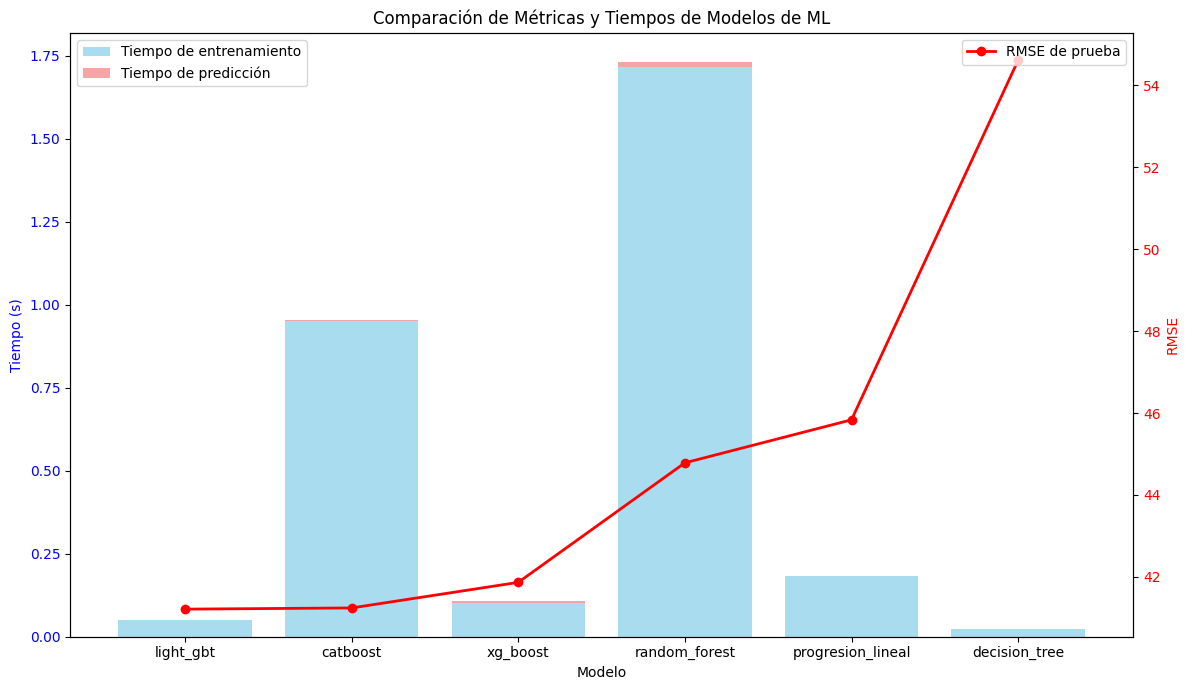

In [8]:
RESULT_SAVE_PATH ='../data/processed/results.parquet'
df_results = pd.read_parquet(RESULT_SAVE_PATH)

plot_model_comparison(
    df_results,
    save_path='../reports/figures/rmse_time_comparing_by_models.png'
    )

### Análisis de Predicciones de modelos

Gráfico de predicciones guardado en: reports/figures/final_model_predictions_vs_actual.png


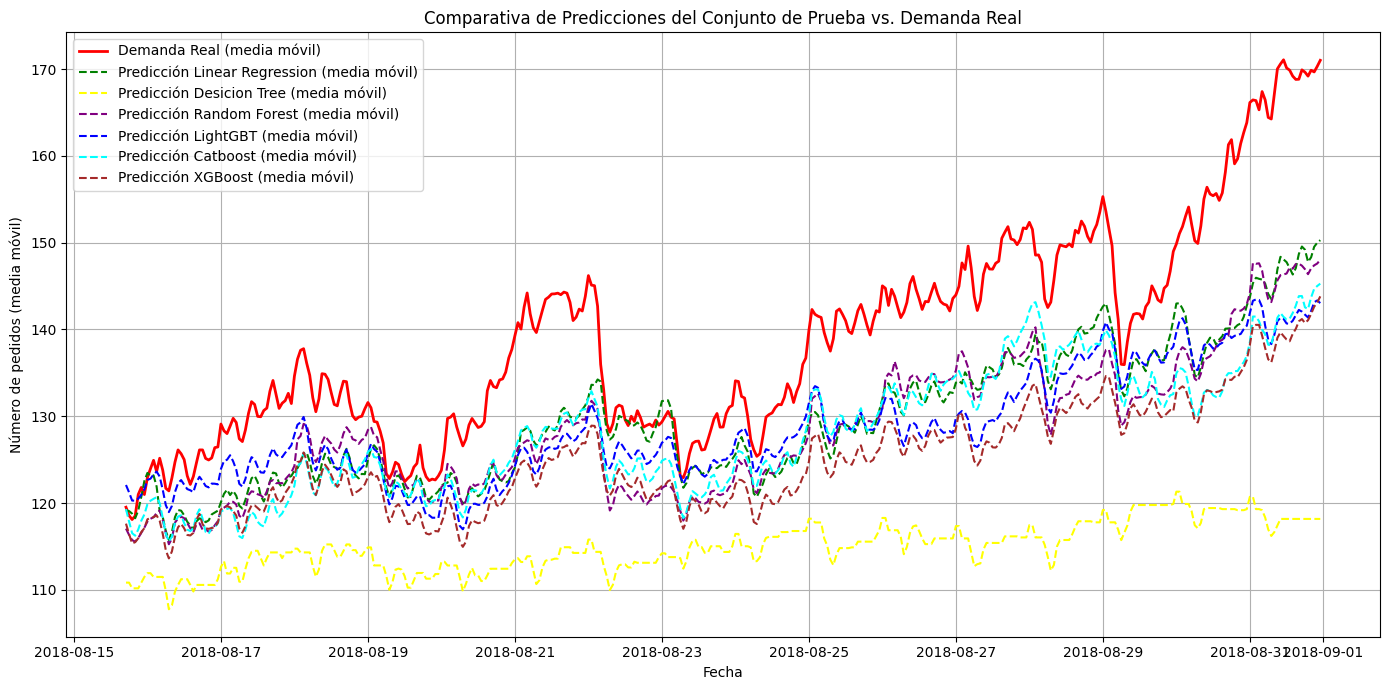

In [ ]:
if df_resampled is not None and predictions_test_values is not None:

    prediction_dfs_for_plot = {
        'Linear Regression': pd.DataFrame(predictions_test_values['predicted_lr'].values, index=target_test.index, columns=['num_orders']),
        'Desicion Tree': pd.DataFrame(predictions_test_values['predicted_dt'].values, index=target_test.index, columns=['num_orders']),
        'Random Forest': pd.DataFrame(predictions_test_values['predicted_rf'].values, index=target_test.index, columns=['num_orders']),
        'LightGBT': pd.DataFrame(predictions_test_values['predicted_lgbt'].values, index=target_test.index, columns=['num_orders']),
        'Catboost': pd.DataFrame(predictions_test_values['predicted_cb'].values, index=target_test.index, columns=['num_orders']),
        'XGBoost': pd.DataFrame(predictions_test_values['predicted_xgb'].values, index=target_test.index, columns=['num_orders']),
    }

    test_start_date = target_test.index.min()
    test_end_date = target_test.index.max()
    
    original_test_slice = df_resampled.loc[test_start_date:test_end_date]


    plot_test_predictions(
        original_test_slice,
        prediction_dfs_for_plot,
        start_date=test_start_date.strftime('%Y-%m-%d'),
        save_path='../reports/figures/final_model_predictions_vs_actual.png'
    )
else:
    print("No se pueden generar gráficos de predicciones porque faltan datos o predicciones.")


### Conclusiones

Entre los modelos evaluados, si bien casi todos lograron los resultados esperados en cuanto a lo que se refiere a requerimientos, el modelo realizado con LightGBT fue el que tuvo mejor performance. Esto se puede verificar en el gráfico de barras, en el cual se muestra el menor error, y el menor tiempo de aprendizaje/evaluación.